## Scatterplot of mean degree vs number of nodes for Random Geometric Graphs with color representing quality of fit

In [ ]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import sys, os, webbrowser
import warnings

# --- NEW IMPORTS FOR ML ---
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from RGG_Library import RGGBuilder, RGGVisualizer

space_ = "torus"
use_angles = True
features_ = [0, "invdegfixed"][0]
perturb_bool = False

def run_simulation(n=1000, k=1.01, nsamples=1000, iteration=0):
    # --- RGG GENERATION ---
    builder = RGGBuilder(n=n, k=k, connectivity_regime="sc", space=space_, order=4, perturb = perturb_bool, seed=iteration) 
    
    G = builder.build()

    # --- Manually ensure Giant Component (GC) is used ---
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        if components:
            Gsub = G.subgraph(max(components, key=len)).copy()
        else:
            print(f"Warning: Graph is empty in iteration {iteration}. Skipping.")
            return
    else:
        Gsub = G

    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")
    
    # Graph Stats
    builder.print_graph_stats(G, radius=builder.radius)
    builder.plot_degree_distribution(Gsub)

    # --- Sampling ---
    random.seed(iteration)
    np.random.seed(iteration)
    
    if use_angles:
        res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
            Gsub, nsamples=nsamples, n_bins=20, seed=iteration, min_dist =  builder.radius, max_dist = 2
        )
    else:
        res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
            Gsub, nsamples=nsamples, n_bins=20, seed=iteration, min_dist = builder.radius, max_dist = 2
        )

    if len(res) < 10:
        return G, Gsub

    # ---------------------------
    # FEATURE ENGINEERING
    # ---------------------------
    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9

    current_angles = angles if use_angles else np.zeros_like(dists)
    
    feature_dict = {
            "Dist^2": dists**2,
            "Log(Dist)": np.log(safe_dists),
            "d^4 * cos(4theta)": dists**4 * np.cos(4*current_angles),
            "d^8 * cos(8theta)": dists**8 * np.cos(8*current_angles),
            "InvDegSum": degs,
    }

    feature_names = list(feature_dict.keys())
    X = np.column_stack(list(feature_dict.values()))
    y = res

    # ---------------------------
    # LASSO REGRESSION (L1)
    # ---------------------------
    
    # We train on Scaled Data to let Lasso work effectively
    model = make_pipeline(
        StandardScaler(), 
        Lasso(alpha=1e-6, random_state=0, max_iter=50000)
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        model.fit(X, y)

    # ---------------------------
    # EXTRACT COEFFICIENTS & PREDICT MANUALLY
    # ---------------------------
    
    # 1. Get components from pipeline
    lasso = model.named_steps['lasso']
    scaler = model.named_steps['standardscaler']
    
    # 2. Get Scaled Coefficients (for Feature Importance)
    scaled_coefs = lasso.coef_
    scaled_intercept = lasso.intercept_
    
    # 3. Calculate Unscaled (Real) Coefficients (for Physical Formula)
    # Real_Beta = Scaled_Beta / Sigma
    # Real_Intercept = Scaled_Intercept - Sum(Real_Beta * Mean)
    sigmas = scaler.scale_
    means = scaler.mean_
    
    real_coefs = scaled_coefs / sigmas
    real_intercept = scaled_intercept - np.sum(real_coefs * means)

    # 4. Generate Predictions using REAL coefficients (Manual Calculation)
    # This verifies that the unscaled formula works
    y_pred_manual = (X @ real_coefs) + real_intercept
    
    # Calculate residuals and score based on this manual prediction
    residuals = y - y_pred_manual
    
    # Recalculate R2 manually to be sure
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    manual_r2 = 1 - (ss_res / ss_tot)

    print(f"\nAlpha (User-defined): {lasso.alpha:.6f}")
    print(f"Lasso R² (Calculated from Real Coefs): {manual_r2:.4f}")
    
    # --- PART 1: Scaled Coefficients (Feature Importance) ---
    print("\n[Scaled] Feature Importance (Relative Strength):")
    print("-" * 50)
    
    sorted_idx = np.argsort(np.abs(scaled_coefs))[::-1]
    
    found_any = False
    for i in sorted_idx:
        if abs(scaled_coefs[i]) > 1e-6: 
            print(f"{feature_names[i]:<20} : {scaled_coefs[i]:.6f}")
            found_any = True
    
    if not found_any:
        print("(Lasso shrank all coefficients to zero - try a smaller alpha)")
    print("-" * 50)

    # --- PART 2: Unscaled Coefficients (The Physical Equation) ---
    print("\n[Unscaled] Physical Formula (True Units):")
    print(f"Real Intercept       : {real_intercept:.6f}")
    print("-" * 50)
    
    for i in sorted_idx:
        if abs(scaled_coefs[i]) > 1e-6: 
            print(f"{feature_names[i]:<20} : {real_coefs[i]:.8f}")
    print("-" * 50)


    # ---------------------------
    # VISUALIZATION
    # ---------------------------
    fig = plt.figure(figsize=(12, 10))
    cmap = "viridis"

    # 1. Feature Importance (Top Left - 2D)
    ax1 = fig.add_subplot(2, 2, 1)
    # Plot scaled coefs to show importance
    ax1.barh(feature_names, scaled_coefs, color='teal')
    ax1.axvline(0, color='k', linewidth=0.8)
    ax1.set_title("Lasso Feature Importance (Scaled)")
    ax1.set_xlabel("Coefficient Magnitude")

    # 2. Fit: Predicted vs Observed (Top Right - 2D)
    ax2 = fig.add_subplot(2, 2, 2)
    # Uses y_pred_manual
    sc1 = ax2.scatter(y_pred_manual, y, c=degs, cmap=cmap, alpha=0.5, s=15)
    lims = [min(y.min(), y_pred_manual.min()), max(y.max(), y_pred_manual.max())]
    ax2.plot(lims, lims, 'r--', lw=1.5)
    ax2.set_title(f"Model Fit (R²={manual_r2:.3f})")
    ax2.set_xlabel("Predicted Resistance (Manual Unscaled)")
    ax2.set_ylabel("Observed Resistance")
    plt.colorbar(sc1, ax=ax2, label="1/du + 1/dv")

    # 3. Residuals vs Distance (Bottom Left - 2D)
    ax3 = fig.add_subplot(2, 2, 3)
    # Uses residuals from y_pred_manual
    sc2 = ax3.scatter(dists, residuals, c=degs, cmap=cmap, alpha=0.5, s=15)
    ax3.axhline(0, color='r', linestyle='--')
    ax3.set_title("Residuals vs Distance")
    ax3.set_xlabel("Toroidal Distance")
    ax3.set_ylabel("Residual (Obs - Pred)")
    plt.colorbar(sc2, ax=ax3, label="1/du + 1/dv")

    # 4. 3D PLOT
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    sc3 = ax4.scatter(dists, degs, y, c=degs, cmap=cmap, alpha=0.4, s=20, label='Observed')
    
    # Uses y_pred_manual
    ax4.scatter(dists, degs, y_pred_manual, c='k', alpha=0.2, s=5, label='Predicted (Formula)')

    ax4.set_title("3D Profile: Dist vs Deg vs Res")
    ax4.set_xlabel("Distance")
    ax4.set_ylabel("Inv Deg Sum")
    ax4.set_zlabel("Resistance")
    ax4.legend()
    ax4.view_init(elev=15, azim=315)
    plt.colorbar(sc3, ax=ax4, label="1/du + 1/dv")

    plt.tight_layout()
    plt.show()

    return G, Gsub

# ---------------------------
# RUN
# ---------------------------1

G, Gsub = run_simulation(n = 1000, k=20, nsamples=2000, iteration=0)

[1/16] Running n=500, k=5 ...  R² = 0.3227
[2/16] Running n=500, k=10 ...  R² = 0.8091
[3/16] Running n=500, k=15 ...  R² = 0.9377
[4/16] Running n=500, k=20 ...  R² = 0.9670
[5/16] Running n=1000, k=5 ...  R² = 0.2386
[6/16] Running n=1000, k=10 ...  R² = 0.8546
[7/16] Running n=1000, k=15 ...  R² = 0.9194
[8/16] Running n=1000, k=20 ...  R² = 0.9495
[9/16] Running n=1500, k=5 ...  R² = 0.1858
[10/16] Running n=1500, k=10 ...  R² = 0.8616
[11/16] Running n=1500, k=15 ...  R² = 0.9509
[12/16] Running n=1500, k=20 ...  R² = 0.9615
[13/16] Running n=2000, k=5 ...  R² = 0.2653
[14/16] Running n=2000, k=10 ...  R² = 0.8531
[15/16] Running n=2000, k=15 ...  R² = 0.9423
[16/16] Running n=2000, k=20 ...  R² = 0.9716


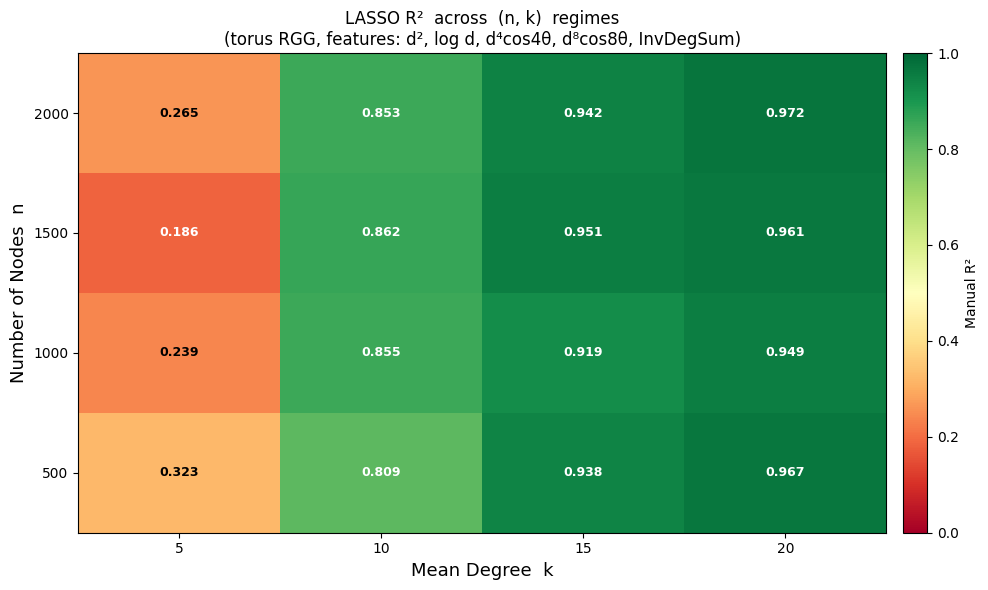


Done. Saved to r2_heatmap.png


In [2]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from RGG_Library import RGGBuilder

space_ = "torus"
use_angles = True
perturb_bool = False

# ---------------------------
# GRID PARAMETERS
# ---------------------------
n_values = [500, 1000, 1500, 2000]       # rows of heatmap
k_values = [5, 10, 15, 20]            # columns of heatmap
nsamples = 1000
iteration = 0

# ---------------------------
# REFACTORED CORE FUNCTION
# ---------------------------
def compute_r2(n, k, nsamples=1000, iteration=0):
    """Run simulation for given (n, k) and return LASSO R². Returns NaN on failure."""
    try:
        builder = RGGBuilder(
            n=n, k=k, connectivity_regime="sc",
            space=space_, order=4, perturb=perturb_bool, seed=iteration
        )
        G = builder.build()

        # Use giant component
        if not nx.is_connected(G):
            components = list(nx.connected_components(G))
            if not components:
                return np.nan
            Gsub = G.subgraph(max(components, key=len)).copy()
        else:
            Gsub = G

        Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")

        random.seed(iteration)
        np.random.seed(iteration)

        if use_angles:
            res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
                Gsub, nsamples=nsamples, n_bins=20, seed=iteration,
                min_dist=builder.radius, max_dist=2
            )
        else:
            res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
                Gsub, nsamples=nsamples, n_bins=20, seed=iteration,
                min_dist=builder.radius, max_dist=2
            )

        if len(res) < 10:
            return np.nan

        # Feature engineering
        safe_dists = dists.copy()
        safe_dists[safe_dists == 0] = 1e-9
        current_angles = angles if use_angles else np.zeros_like(dists)

        X = np.column_stack([
            dists**2,
            np.log(safe_dists),
            dists**4 * np.cos(4 * current_angles),
            dists**8 * np.cos(8 * current_angles),
            degs,
        ])
        y = res

        # LASSO
        model = make_pipeline(
            StandardScaler(),
            Lasso(alpha=1e-6, random_state=0, max_iter=50000)
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X, y)

        lasso  = model.named_steps['lasso']
        scaler = model.named_steps['standardscaler']
        real_coefs = lasso.coef_ / scaler.scale_
        real_intercept = lasso.intercept_ - np.sum(real_coefs * scaler.mean_)

        y_pred = X @ real_coefs + real_intercept
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot

        return float(r2)

    except Exception as e:
        print(f"  [WARN] n={n}, k={k} failed: {e}")
        return np.nan


# ---------------------------
# SWEEP OVER GRID
# ---------------------------
R2_grid = np.full((len(n_values), len(k_values)), np.nan)

total = len(n_values) * len(k_values)
done  = 0

for i, n in enumerate(n_values):
    for j, k in enumerate(k_values):
        done += 1
        print(f"[{done}/{total}] Running n={n}, k={k} ...", end="  ")
        r2 = compute_r2(n, k, nsamples=nsamples, iteration=iteration)
        R2_grid[i, j] = r2
        print(f"R² = {r2:.4f}" if not np.isnan(r2) else "R² = NaN")


# ---------------------------
# HEATMAP PLOT
# ---------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Mask NaN cells so they show as grey
masked = np.ma.array(R2_grid, mask=np.isnan(R2_grid))
cmap = plt.cm.RdYlGn.copy()
cmap.set_bad(color='lightgrey')

im = ax.imshow(
    masked,
    aspect='auto',
    cmap=cmap,
    vmin=0, vmax=1,
    origin='lower'          # n increases upward
)

# Axis labels
ax.set_xticks(range(len(k_values)))
ax.set_xticklabels([str(k) for k in k_values])
ax.set_yticks(range(len(n_values)))
ax.set_yticklabels([str(n) for n in n_values])
ax.set_xlabel("Mean Degree  k", fontsize=13)
ax.set_ylabel("Number of Nodes  n", fontsize=13)
ax.set_title("LASSO R²  across  (n, k)  regimes\n(torus RGG, features: d², log d, d⁴cos4θ, d⁸cos8θ, InvDegSum)", fontsize=12)

# Annotate each cell with its R² value
for i in range(len(n_values)):
    for j in range(len(k_values)):
        val = R2_grid[i, j]
        if not np.isnan(val):
            text_color = "black" if 0.2 < val < 0.8 else "white"
            ax.text(j, i, f"{val:.3f}", ha='center', va='center',
                    fontsize=9, color=text_color, fontweight='bold')
        else:
            ax.text(j, i, "NaN", ha='center', va='center',
                    fontsize=8, color='grey')

plt.colorbar(im, ax=ax, label="Manual R²", fraction=0.03, pad=0.02)
plt.tight_layout()
plt.savefig("r2_heatmap.png", dpi=150)
plt.show()

print("\nDone. Saved to r2_heatmap.png")

In [14]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from RGG_Library import RGGBuilder

space_ = "torus"
use_angles = True
perturb_bool = False

# ---------------------------
# GRID PARAMETERS
# ---------------------------
n_values = [256, 512, 1024, 2048, 4096, 8192]
k_values = [15, 20]
nsamples = 1000       # samples per graph
n_train_graphs = 100    # graphs to pool for training
n_test_graphs  = 20    # graphs to pool for testing
base_seed      = 0    # train seeds: base_seed + 0..4, test seeds: base_seed + 5..7

# ---------------------------
# HELPER: build graph & extract features
# ---------------------------
def build_features(n, k, nsamples, seed):
    """
    Build one RGG and return (X, y). Returns (None, None) on failure.
    """
    builder = RGGBuilder(
        n=n, k=k, connectivity_regime="sc",
        space=space_, order=4, perturb=perturb_bool, seed=seed
    )
    G = builder.build()

    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        if not components:
            return None, None
        Gsub = G.subgraph(max(components, key=len)).copy()
    else:
        Gsub = G

    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")

    random.seed(seed)
    np.random.seed(seed)

    if use_angles:
        res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
            Gsub, nsamples=nsamples, n_bins=20, seed=seed,
            min_dist=builder.radius, max_dist=2
        )
    else:
        res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
            Gsub, nsamples=nsamples, n_bins=20, seed=seed,
            min_dist=builder.radius, max_dist=2
        )

    if len(res) < 10:
        return None, None

    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9
    current_angles = angles if use_angles else np.zeros_like(dists)

    X = np.column_stack([
        dists**2,
        np.log(safe_dists),
        dists**4 * np.cos(4 * current_angles),
        dists**8 * np.cos(8 * current_angles),
        degs,
    ])
    y = np.array(res)

    return X, y


# ---------------------------
# CORE FUNCTION
# ---------------------------
def compute_r2(n, k, nsamples=1000, base_seed=0):
    """
    Train LASSO on n_train_graphs pooled graphs, test on n_test_graphs pooled graphs.
    Returns out-of-sample R². Returns NaN on failure.
    """
    try:
        # --- TRAINING: pool data from n_train_graphs graphs ---
        X_train_parts, y_train_parts = [], []
        for i in range(n_train_graphs):
            X, y = build_features(n, k, nsamples, seed=base_seed + i)
            if X is not None:
                X_train_parts.append(X)
                y_train_parts.append(y)

        if len(X_train_parts) == 0:
            return np.nan

        X_train = np.vstack(X_train_parts)
        y_train = np.concatenate(y_train_parts)

        # --- FIT LASSO ---
        model = make_pipeline(
            StandardScaler(),
            Lasso(alpha=1e-6, random_state=0, max_iter=50000)
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)

        lasso  = model.named_steps['lasso']
        scaler = model.named_steps['standardscaler']
        real_coefs     = lasso.coef_ / scaler.scale_
        real_intercept = lasso.intercept_ - np.sum(real_coefs * scaler.mean_)

        # --- TESTING: pool data from n_test_graphs new graphs ---
        X_test_parts, y_test_parts = [], []
        for i in range(n_test_graphs):
            # Use seeds that don't overlap with training seeds
            X, y = build_features(n, k, nsamples, seed=base_seed + n_train_graphs + i)
            if X is not None:
                X_test_parts.append(X)
                y_test_parts.append(y)

        if len(X_test_parts) == 0:
            return np.nan

        X_test = np.vstack(X_test_parts)
        y_test = np.concatenate(y_test_parts)

        # --- OUT-OF-SAMPLE R² ---
        y_pred  = X_test @ real_coefs + real_intercept
        ss_res  = np.sum((y_test - y_pred) ** 2)
        ss_tot  = np.sum((y_test - np.mean(y_test)) ** 2)
        r2      = 1 - ss_res / ss_tot

        return float(r2)

    except Exception as e:
        print(f"  [WARN] n={n}, k={k} failed: {e}")
        return np.nan


# ---------------------------
# SWEEP OVER GRID
# ---------------------------
R2_grid = np.full((len(n_values), len(k_values)), np.nan)

total = len(n_values) * len(k_values)
done  = 0

for i, n in enumerate(n_values):
    for j, k in enumerate(k_values):
        done += 1
        print(f"[{done}/{total}] Running n={n}, k={k} ...", end="  ")
        r2 = compute_r2(n, k, nsamples=nsamples, base_seed=base_seed)
        R2_grid[i, j] = r2
        print(f"R² = {r2:.4f}" if not np.isnan(r2) else "R² = NaN")


# ---------------------------
# SCATTER PLOT
# ---------------------------
fig, ax = plt.subplots(figsize=(9, 6))

# Flatten grid into lists of (n, k, r2) points
ns, ks, r2s = [], [], []
for i, n in enumerate(n_values):
    for j, k in enumerate(k_values):
        val = R2_grid[i, j]
        ns.append(n)
        ks.append(k)
        r2s.append(val)

ns   = np.array(ns)
ks   = np.array(ks)
r2s  = np.array(r2s)

# Separate valid and NaN points
valid = ~np.isnan(r2s)

cmap = plt.cm.RdYlGn
norm = plt.Normalize(vmin=0, vmax=1)

sc = ax.scatter(
    ks[valid], ns[valid],
    c=r2s[valid],
    cmap=cmap,
    norm=norm,
    s=400,
    edgecolors='k',
    linewidths=0.6,
    zorder=3
)

# Plot NaN points as grey X markers
if np.any(~valid):
    ax.scatter(
        ks[~valid], ns[~valid],
        c='lightgrey', marker='X', s=200,
        edgecolors='k', linewidths=0.6,
        label='NaN', zorder=3
    )
    ax.legend(fontsize=10)

# Annotate each point with its R² value
for n, k, r2 in zip(ns, ks, r2s):
    if not np.isnan(r2):
        text_color = "black" if 0.2 < r2 else "white"
        ax.annotate(
            f"{r2:.3f}", (k, n),
            ha='center', va='center',
            fontsize=7.5, fontweight='bold', color=text_color,
            zorder=4
        )

# Curve: ln(n) = k  →  n = e^k
k_curve = np.linspace(min(k_values), max(k_values), 300)
n_curve = np.exp(k_curve)
ax.plot(k_curve, n_curve, 'b--', linewidth=1.8, label=r'$\ln(n) = k$', zorder=2)
ax.legend(fontsize=10)

plt.colorbar(sc, ax=ax, label="Out-of-Sample R²", fraction=0.03, pad=0.02)

ax.set_xlabel("Mean Degree  k", fontsize=13)
ax.set_ylabel("Number of Nodes  n", fontsize=13)
ax.set_title(
    f"LASSO Out-of-Sample R²  across  (n, k)  regimes\n"
    f"(Train: {n_train_graphs} graphs × {nsamples} pts  |  Test: {n_test_graphs} graphs × {nsamples} pts)",
    fontsize=12
)

ax.set_xticks(k_values)
ax.set_yticks(n_values)
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yscale('log')
ax.grid(True, linestyle='--', alpha=0.4, zorder=0)

plt.tight_layout()
plt.show()

[1/12] Running n=256, k=15 ...  R² = 0.9383
[2/12] Running n=256, k=20 ...  R² = 0.9668
[3/12] Running n=512, k=15 ...  R² = 0.9266
[4/12] Running n=512, k=20 ...  R² = 0.9601
[5/12] Running n=1024, k=15 ...  R² = 0.9307
[6/12] Running n=1024, k=20 ...  

KeyboardInterrupt: 